In [1]:
import scipy.io.wavfile as wav
import scipy.signal as sig

import matplotlib.pyplot as plt
import numpy as np

import IPython.display as ipd

import numpy as np
from numpy.linalg import norm
from spectrum import arburg

from spectrum.burg import _arburg2
from scipy.signal import lfilter, lfiltic
from tqdm import tqdm, tqdm_notebook as tn

In [2]:
def LPC(previous_sig, next_sig, gap_start, gap_end, lpc_order):

    target_length = gap_end - gap_start
    
    ab, _, _ = _arburg2(previous_sig, lpc_order)
    Zb = lfiltic(b=[1], a=ab, y=previous_sig[:-lpc_order-1:-1])
    forw_pred, _ = lfilter(b=[1], a=ab, x=np.zeros((target_length)), zi=Zb)

    next_sig = np.flipud(next_sig)
    af, _, _ = _arburg2(next_sig, lpc_order)
    Zf = lfiltic([1], af, next_sig[:-lpc_order-1:-1])
    backw_pred, _ = lfilter([1], af, np.zeros((target_length)), zi=Zf)
    backw_pred = np.flipud(backw_pred)

    t = np.linspace(0, np.pi/2, target_length)
    sqCos = np.cos(t)**2
    sigout = sqCos*forw_pred + np.flipud(sqCos)*backw_pred
    return sigout

In [3]:
SNR = lambda y, y_hat: 20 * (np.log10(norm(y)) - np.log10(norm(y-y_hat)))

In [4]:
def plot_signal_by_parts(signal, gap_start, gap_end, gap=None):
    if gap is None:
        plt.title("Original signal")
        plt.plot(np.arange(gap_start), signal[:gap_start])
        plt.plot(np.arange(gap_start, gap_end), signal[gap_start:gap_end])
        plt.plot(np.arange(gap_end, len(signal)), signal[gap_end:])
    else:
        plt.title("Reconstructed signal")
        plt.plot(np.arange(gap_start), signal[:gap_start])
        plt.plot(np.arange(gap_start, gap_end), gap)
        plt.plot(np.arange(gap_end, len(signal)), signal[gap_end:])
    
    plt.show()

# TESTING WITH RML

In [5]:
from mlp import audio
from mlp import normalization
from mlp import utils as mlp
from mlp.dataset import WAVAudioDS, TimePostprocessing, WAVTimeAudioDS, PolarPreprocessing
from multiprocessing import Pool
from multiprocessing.pool import ThreadPool
import multiprocessing

import pickle
import torch

In [6]:
fs = 48000
bs = 1
stroke_width_ms = 32
patch_width = 64
patch_height = 64

In [7]:
preprocess = PolarPreprocessing(
    normalization.norm_mag, 
    normalization.norm_phase, 
    patch_width, 
    patch_height
)


# stroke_mask = mlp.build_stroke_purge_mask(patch_width, patch_height, stroke_width_ms, fs, nperseg=256)
time_mask = mlp.build_time_purge_mask(patch_width, stroke_width_ms, fs)

val_files = pickle.load(open("valid.pk", "rb"))

torch.multiprocessing.set_sharing_strategy('file_system') # I was getting memory errors without this line.
with Pool(8) as p:
    ds_valid = WAVTimeAudioDS(files=val_files, mk_source=lambda x: x * time_mask, preprocess=preprocess, 
                          patch_width=patch_width, proc_pool=p, fs=fs, random_patches=False) 

100%|██████████| 4000/4000 [05:08<00:00, 17.01it/s]


In [8]:
len(ds_valid)

77928

In [9]:
import lpc

In [20]:
context_size = int(69 * fs / 1000)
lpc_order = 1000
rec_signals = []
n_threads = 6
# chunksize = len(ds_valid) / (n_threads * 4)

chunksize = 250

  0%|          | 253/77928 [02:06<10:18:54,  2.09it/s]

In [ ]:
!python lpc.py

 56%|█████████████████████▉                 | 2250/4000 [01:59<00:55, 31.30it/s]

In [18]:
import mlp.complx as complx

def get_norm_mag_from_freqs(freqs):
    freqs[0], freqs[1] = complx.to_polar(freqs)
    freqs[0], freqs[1] = normalization.norm_mag(freqs[0]), normalization.norm_phase(freqs[1])
    return freqs[0]

def reconstruct_with_target_phase(lpc_signal, target):
    _, _, target = audio.stft(target, fs=fs, nperseg=256)
    target = target[:,:-2]
    target = WAVAudioDS.freqs_to_torch(target, max_freqs=64)  
    target[0], target[1] = complx.to_polar(target)
    target[0], target[1] = normalization.norm_mag(target[0]), normalization.norm_phase(target[1])

    _, _, lpc_signal = audio.stft(lpc_signal, fs=fs, nperseg=256)
    lpc_signal = lpc_signal[:,:-2]
    lpc_signal = WAVAudioDS.freqs_to_torch(lpc_signal, max_freqs=64)
    lpc_signal[0], lpc_signal[1] = complx.to_polar(lpc_signal)
    lpc_signal[0], lpc_signal[1] = normalization.norm_mag(lpc_signal[0]), normalization.norm_phase(lpc_signal[1])
    
    rec_signal = torch.stack([lpc_signal[0], target[1]])
    rec_signal = audio.torch_out_to_time_domain([rec_signal])[0]
    target_signal = audio.torch_out_to_time_domain([target])[0]
    
    return rec_signal, lpc_signal[0], target_signal, target[0]


mse = lambda y, y_hat: ((y - y_hat)**2).mean()

0it [00:00, ?it/s]

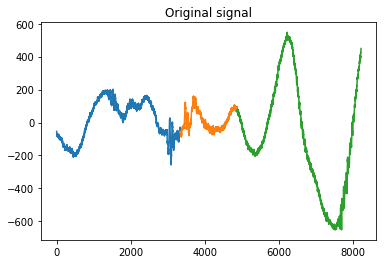

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


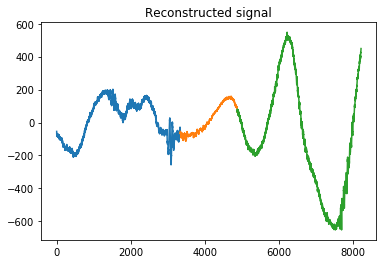

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part

  0%|          | 0/1 [00:00<?, ?it/s]
1it [00:00,  2.89it/s]
  0%|          | 0/1 [00:00<?, ?it/s]
5it [00:00,  3.97it/s]
  0%|          | 0/1 [00:00<?, ?it/s]
8it [00:00,  5.30it/s]
  0%|          | 0/1 [00:00<?, ?it/s]
11it [00:00,  7.04it/s]
  0%|          | 0/1 [00:00<?, ?it/s]
14it [00:00,  9.10it/s]
  0%|          | 0/1 [00:00<?, ?it/s]
17it [00:00, 11.45it/s]
  0%|          | 0/1 [00:00<?, ?it/s]
20it [00:01, 13.98it/s]
  0%|          | 0/1 [00:00<?, ?it/s]
22it [00:01, 20.30it/s]


In [19]:
mse_list = []
snr_list = []
snr_list_or_phase = []

for i, (lpc_signal, (src, target)) in tqdm(enumerate(zip(rec_signals, ds_valid))):

    if lpc_signal is None:
        continue
        
    sample_length = len(target)
    sample_ms = int(np.floor(32 * fs / 1000))
    gap_start = sample_length // 2 - sample_ms // 2
    gap_end = gap_start + sample_ms
    
    if i == 0:
        plot_signal_by_parts(target, gap_start, gap_end)
        plot_signal_by_parts(target, gap_start, gap_end, lpc_signal)

    snr_list.append(SNR(target[gap_start:gap_end], lpc_signal))
    
    lpc_signal = np.concatenate([target[:gap_start], lpc_signal, target[gap_end:]]).astype(np.float32)    
    rec_signal_time, rec_signal_mag, target_time, target_mag = reconstruct_with_target_phase(lpc_signal, target)
    
    snr_list_or_phase.append(SNR(target_time[gap_start:gap_end], rec_signal_time[gap_start:gap_end]))
    mse_list.append(mse(target_mag[:, 26:38], rec_signal_mag[:, 26:38]))

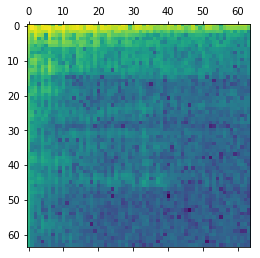

In [20]:
plt.matshow(target_mag)

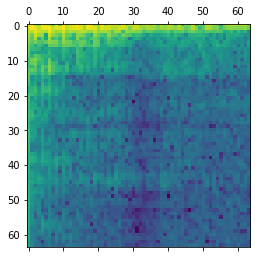

In [21]:
plt.matshow(rec_signal_mag, vmin=np.min(target_mag.numpy()), vmax=np.max(target_mag.numpy()))

In [22]:
mse(target_mag[:, 26:38], rec_signal_mag[:, 26:38])

tensor(0.3610)

# Mean SNR and MSE

LPC
SNR: 1.9120612680271727
SNR std: 3.285468822642674


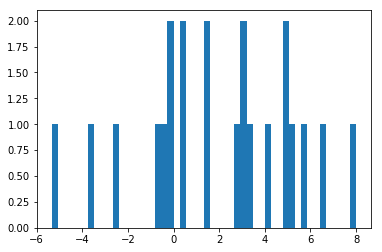

In [23]:
print('LPC')
print('SNR:', np.mean(snr_list))
print('SNR std:', np.std(snr_list))
counts, bins, _ = plt.hist(snr_list, bins=50)

LPC
SNR: 11.146632217282576
SNR std: 0.6059719702820122


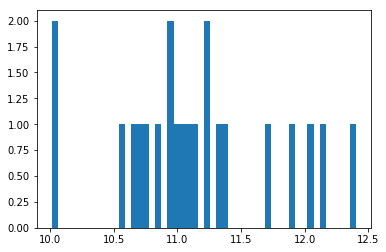

In [24]:
print('LPC')
print('SNR:', np.mean(snr_list_or_phase))
print('SNR std:', np.std(snr_list_or_phase))
counts, bins, _ = plt.hist(snr_list_or_phase, bins=50)

LPC
MSE: 0.33847597
MSE std: 0.11073126


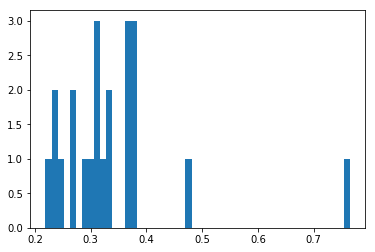

In [25]:
print('LPC')
print('MSE:', np.mean(mse_list))
print('MSE std:', np.std(mse_list))
_ = plt.hist(mse_list, bins=50)